## Data Preprocessing

In [2]:
import numpy as np
import pandas as pd

sp500 = pd.read_csv('./data/sp500.csv')
sp500['Date'] = pd.to_datetime(sp500['Date'], format='%m/%d/%Y')
sp500.sort_values(by='Date', ascending=True, inplace=True)
sp500['log_returns'] = np.log(sp500['Close/Last'] / sp500['Close/Last'].shift(1))
sp500 = sp500.drop(columns = ['Close/Last', 'Open', 'High', 'Low']).dropna()
sp500_residuals = sp500.log_returns - sp500.log_returns.mean()

sp500.head()

y = sp500_residuals

## Model Fitting and Diagnostics

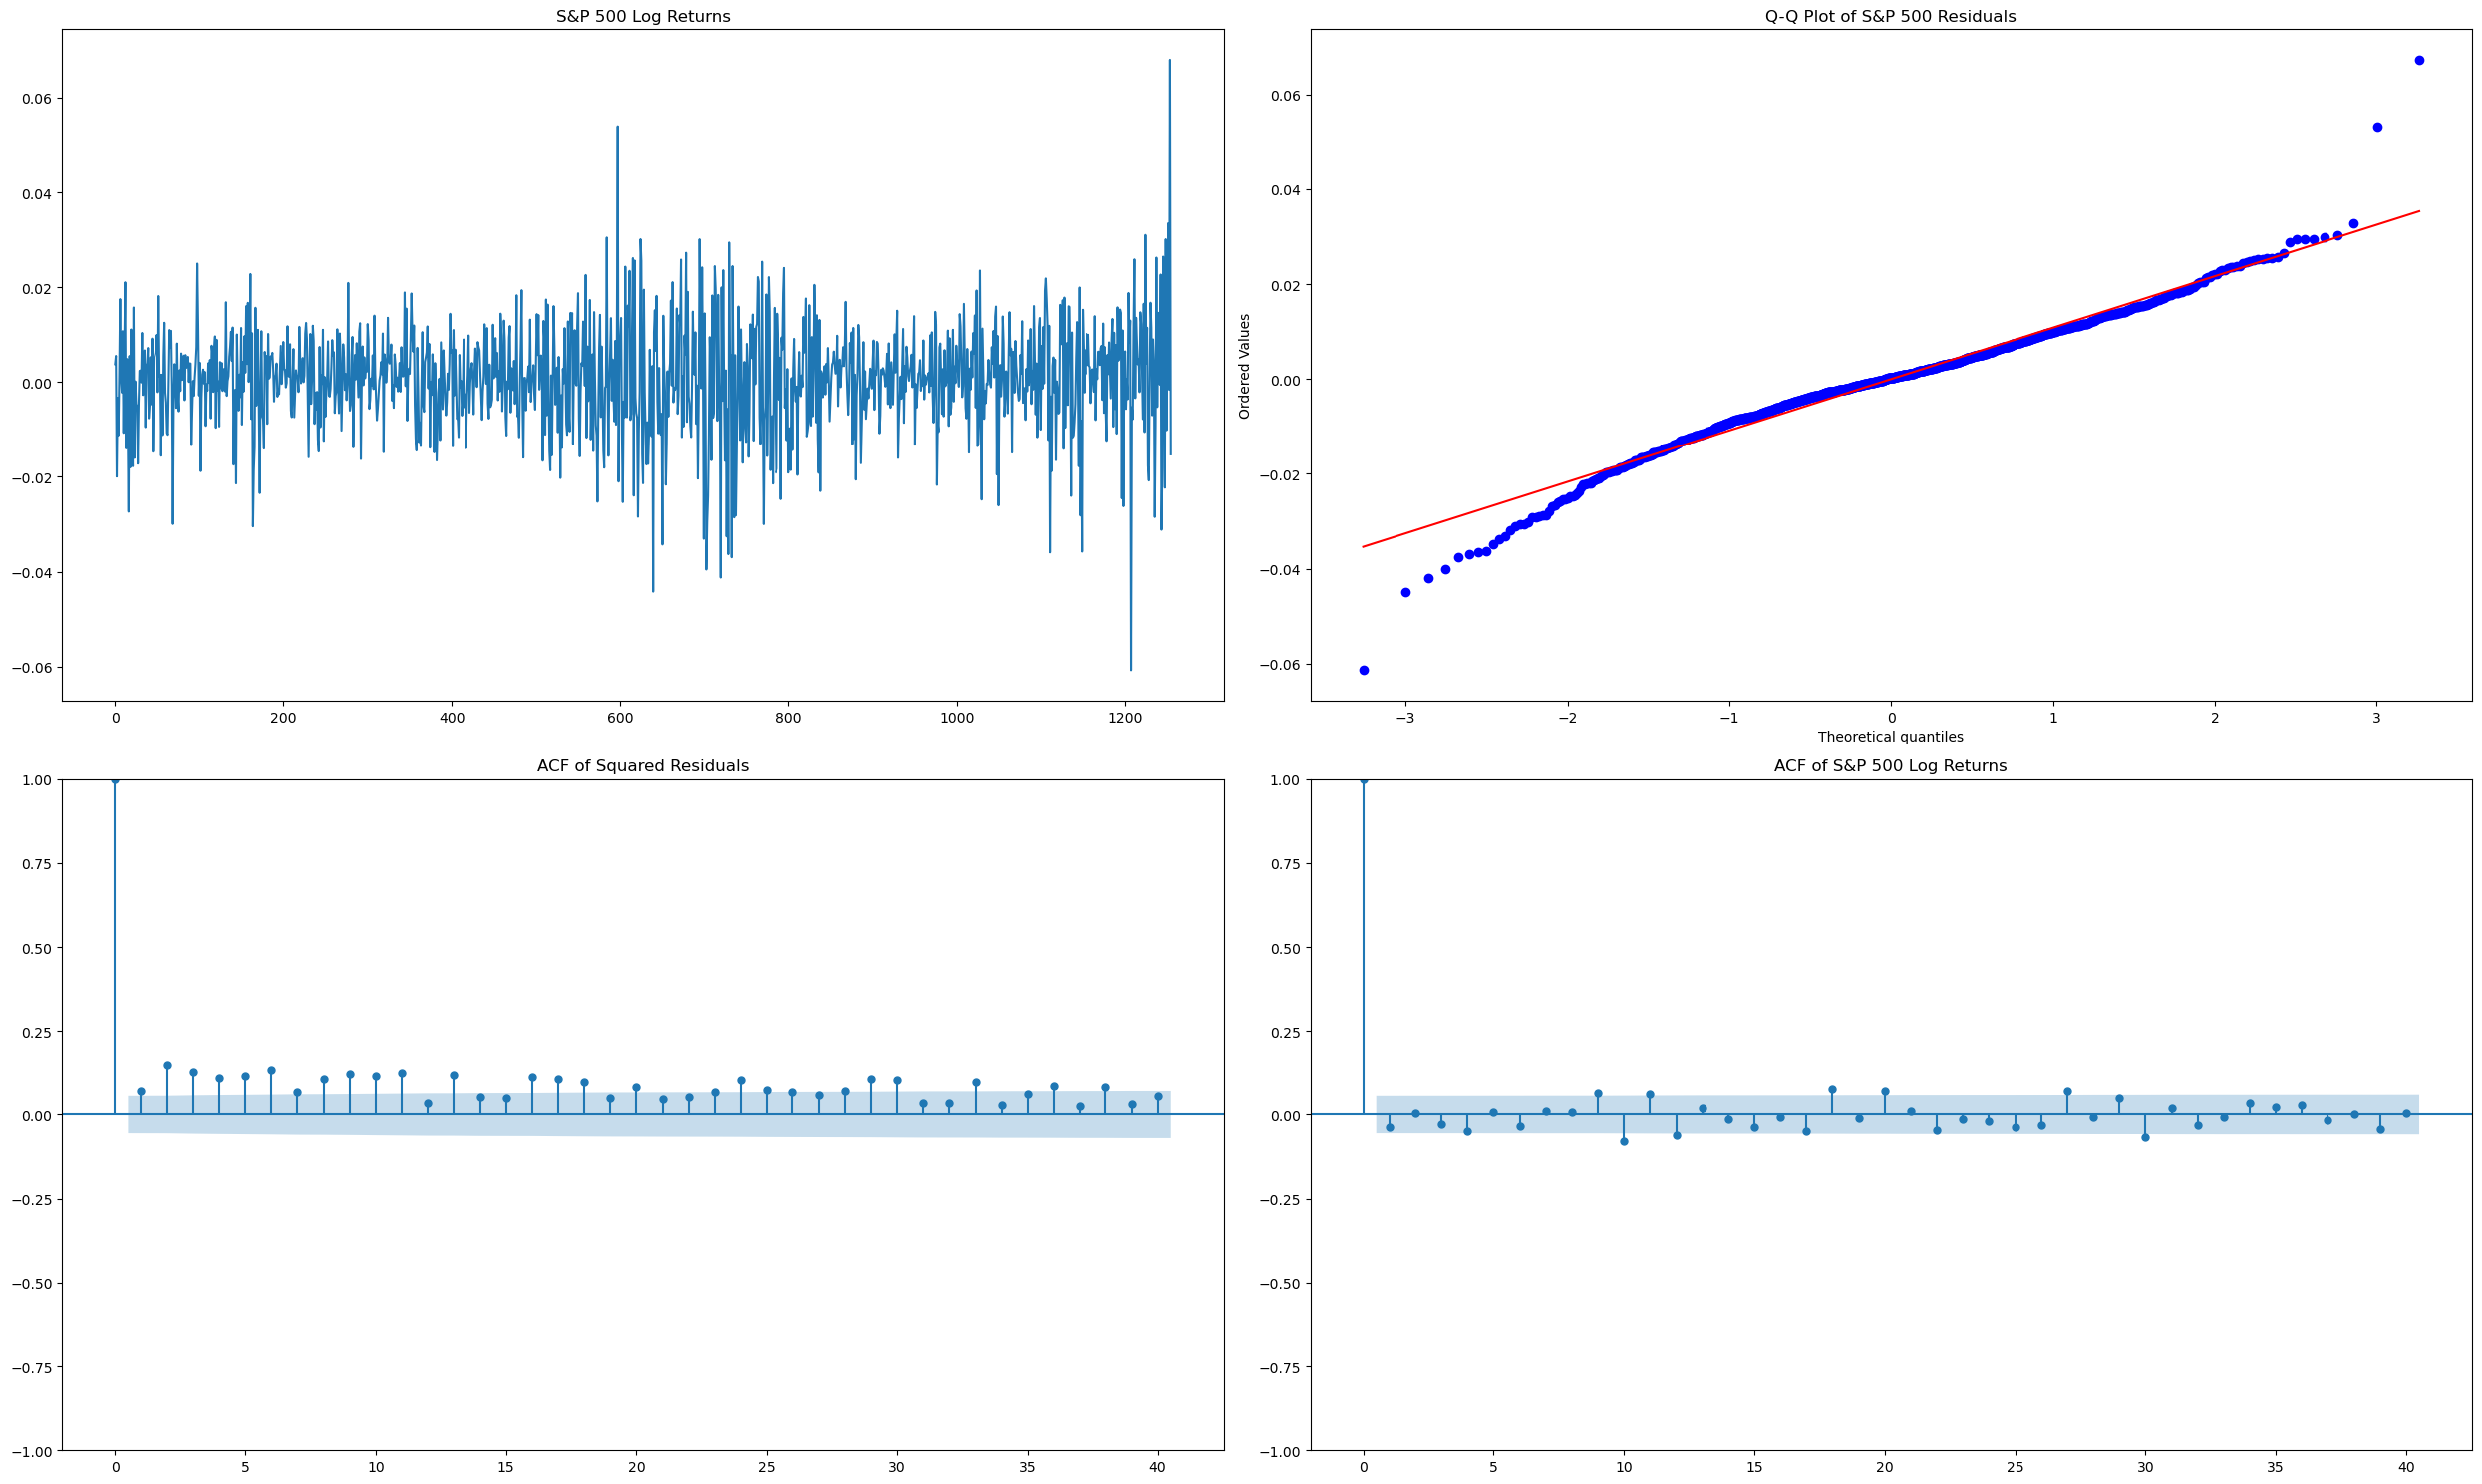

ADF Statistic: -7.759640286643407
p-value: 9.530549001312238e-12


In [3]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats

fig, axs = plt.subplots(2, 2, figsize=(25, 15))

# Plot of Log Returns
axs[0, 0].plot(sp500.log_returns)
axs[0, 0].set_title("S&P 500 Log Returns")

# QQ-Plot of Log Returns
stats.probplot(sp500_residuals, dist="norm", plot=axs[0, 1])
axs[0, 1].set_title("Q-Q Plot of S&P 500 Residuals")

# ACF of Log Returns
plot_acf(sp500.log_returns, lags=40, ax=axs[1, 1])
axs[1, 1].set_title("ACF of S&P 500 Log Returns")

# ACF of Squared Residuals
plot_acf(sp500_residuals**2, lags=40, ax=axs[1, 0])
axs[1, 0].set_title("ACF of Squared Residuals")

plt.tight_layout()
plt.show()

# ADF Test for stationarity
adf_result = adfuller(sp500['log_returns'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")


The underlying ARCH model for GARCH requires stationarity, and from the plot of log returns, it is safe to assume stationarity. The Augmented Dickey-Fuller test confirms this.
The ACF of squared residuals indicates the presence of ARCH effects, further validating the use of a GARCH model. 

In [4]:
## GARCH Model Fitting

Text(0.5, 1.0, 'QQ Plot of Log Returns Residuals')

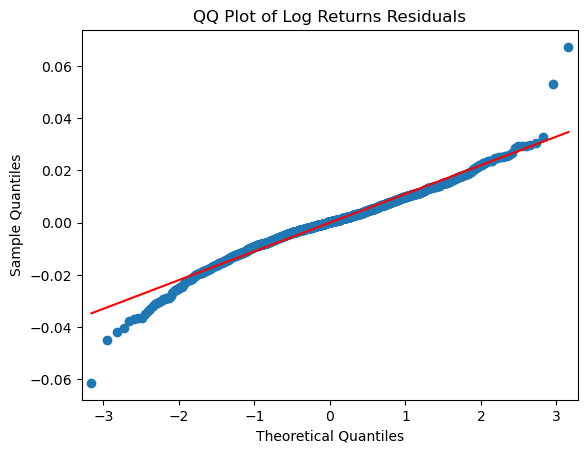

In [7]:
from statsmodels.graphics.api import qqplot

qqplot(sp500_residuals, line='s')
plt.title("QQ Plot of Log Returns Residuals")


(array([ 0.61902317,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.61902317,  0.        ,  0.        ,
         0.61902317,  0.61902317,  0.        ,  1.23804634,  1.23804634,
         0.61902317,  1.23804634,  0.61902317,  1.8570695 ,  0.61902317,
         3.71413901,  1.23804634,  1.8570695 ,  3.09511584,  1.8570695 ,
         3.71413901,  3.71413901,  6.80925485,  7.42827802,  6.80925485,
        11.14241703,  9.28534752, 11.7614402 , 17.33264871, 12.99948653,
        19.18971821, 30.95115841, 25.3799499 , 25.99897306, 37.76041326,
        47.66478395, 45.80771445, 49.52185346, 48.90283029, 44.56966811,
        38.9984596 , 35.28432059, 29.71311207, 27.2370194 , 22.90385722,
        25.3799499 , 23.52288039, 12.99948653, 16.71362554, 11.7614402 ,
         8.04730119,  8.04730119,  4.33316218,  3.09511584,  3.71413901,
         3.09511584,  3.09511584,  4.33316218,  0.6

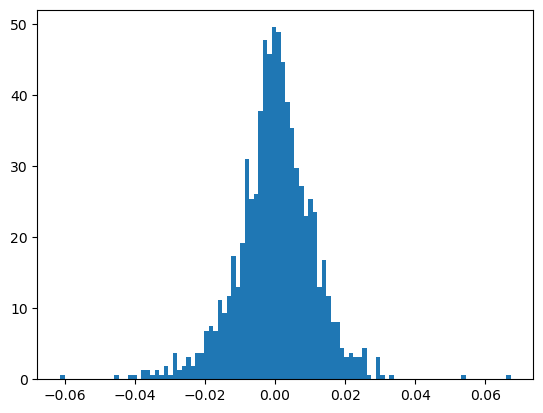

In [8]:
plt.hist(sp500_residuals, bins=100, density=True)


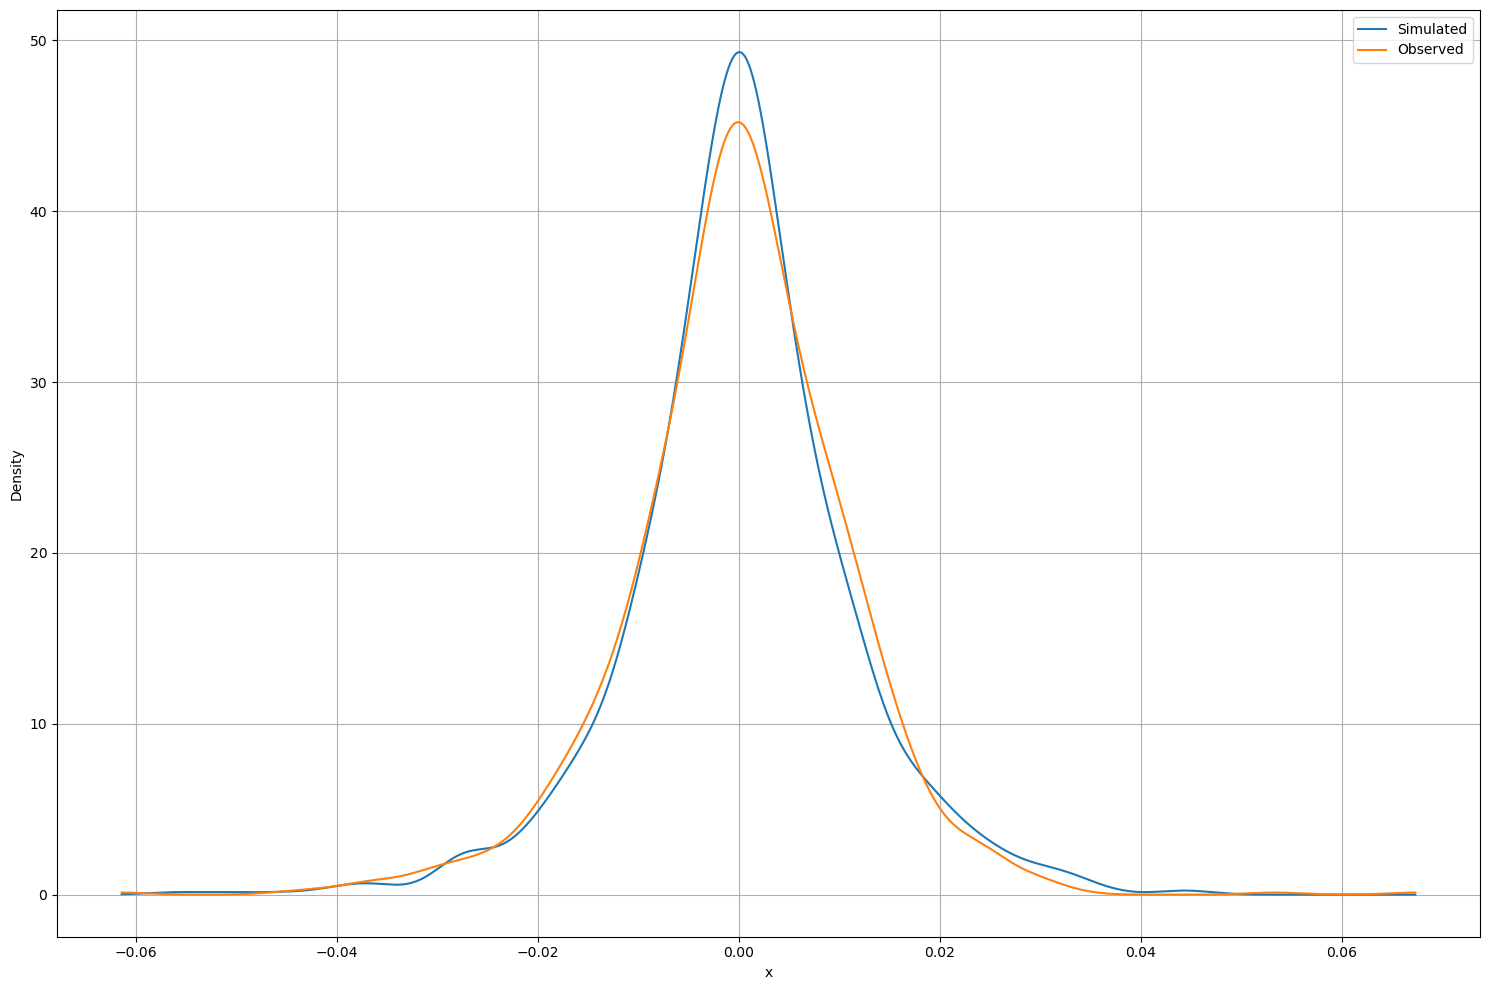

In [9]:
from scipy.stats import gennorm
from scipy.stats import gaussian_kde
sim = gennorm.rvs(1, loc=0, scale=1, size=len(sp500_residuals))
sim_scaled = sim/np.std(sim)*np.std(sp500_residuals) + sp500_residuals.mean()
kde1 = gaussian_kde(sim_scaled)
kde2 = gaussian_kde(sp500_residuals)
xvals = np.linspace(min(sp500_residuals.min(), sim_scaled.min()), max(sp500_residuals.max(), sim_scaled.max()), len(sp500_residuals))

plt.figure(figsize = (15,10))
plt.plot(xvals, kde1(xvals), label='Simulated')
plt.plot(xvals, kde2(xvals), label='Observed')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()